# CS675 Introduction to Data Science - Project #3

**Aayushi Verma**

The aim of this project is to perform time series forecasting for New York City's electric consumption for its 5 boroughs. We use the FB Prophet package to perform most of the analysis in this project.

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import datetime as dt
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from dask.distributed import Client
import itertools

## Step One: Inspecting and Cleaning the Data

This dataset is obtained from: https://data.cityofnewyork.us/Housing-Development/Electric-Consumption-And-Cost-2010-Feb-2022-/jr24-e7cr. It details the monthly consumption and cost data by the 5 boroughs of New York.

In [2]:
raw = pd.read_csv("data.csv")

/var/folders/n9/3mjn__fd1xd66lc1zh9nlj0h0000gp/T/ipykernel_90312/2433355955.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv("data.csv")


In [3]:
raw.head()

,Development Name,Borough,Account Name,Location,Meter AMR,Meter Scope,TDS #,EDP,RC Code,Funding Source,...,Meter Number,Estimated,Current Charges,Rate Class,Bill Analyzed,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges
0,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,15396.82,GOV/NYC/068,Yes,128800,7387.97,216.0,2808.0,5200.85
1,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14556.34,GOV/NYC/068,Yes,115200,6607.87,224.0,2912.0,5036.47
2,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13904.98,GOV/NYC/068,Yes,103200,5919.55,216.0,2808.0,5177.43
3,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14764.04,GOV/NYC/068,Yes,105600,6057.22,208.0,2704.0,6002.82
4,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13729.54,GOV/NYC/068,Yes,97600,5598.34,216.0,2808.0,5323.20


In [58]:
raw['Consumption (KWH)'].describe()

count    4.070310e+05
mean     3.142596e+04
std      4.927138e+04
min      0.000000e+00
25%      0.000000e+00
50%      1.400000e+04
75%      4.640000e+04
max      1.779600e+06
Name: Consumption (KWH), dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x14d5dfe80>,
 'caps': [<matplotlib.lines.Line2D at 0x14d5ec460>,
 'boxes': [<matplotlib.lines.Line2D at 0x14d5ddcf0>],
 'medians': [<matplotlib.lines.Line2D at 0x14d5eca00>],
 'fliers': [<matplotlib.lines.Line2D at 0x14d5eccd0>],
 'means': []}

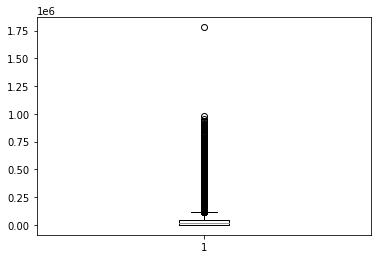

In [59]:
plt.boxplot(raw['Consumption (KWH)'])

In [4]:
raw.shape

(407031, 27)

In [5]:
raw.isnull().sum()

Development Name        1086
Borough                    0
Account Name               0
Location               10625
Meter AMR                186
Meter Scope           385539
TDS #                   2343
EDP                        0
RC Code                    0
Funding Source             0
AMP #                   1886
Vendor Name                0
UMIS BILL ID               0
Revenue Month              0
Service Start Date         8
Service End Date           8
# days                     8
Meter Number               0
Estimated                342
Current Charges            0
Rate Class                 0
Bill Analyzed              0
Consumption (KWH)          0
KWH Charges                0
Consumption (KW)           0
KW Charges                 0
Other charges              0
dtype: int64

In [6]:
df = raw.dropna()
df.isnull().sum()

Development Name      0
Borough               0
Account Name          0
Location              0
Meter AMR             0
Meter Scope           0
TDS #                 0
EDP                   0
RC Code               0
Funding Source        0
AMP #                 0
Vendor Name           0
UMIS BILL ID          0
Revenue Month         0
Service Start Date    0
Service End Date      0
# days                0
Meter Number          0
Estimated             0
Current Charges       0
Rate Class            0
Bill Analyzed         0
Consumption (KWH)     0
KWH Charges           0
Consumption (KW)      0
KW Charges            0
Other charges         0
dtype: int64

In [54]:
df.shape

(21049, 30)

Now that we have cleaned the data, the next step is to consider the data columns we will be using. We are interested in forecasting the electricity consumption of NYC's boroughs over time. So we need a column with dates, a column with energy consumption, and a column for the boroughs. Inspecting the ```df.head()``` we looked at earlier, we see that there are a few date-like columns, and 2 different columns that measure electricity consumption. I have detailed my choices as below:
- Date column: I will use ```Service End Date``` as the date column, since it has dates granular to the date level, instead of e.g. months or years. This will allow for better forecasting because of more data points.
- Energy consumption column: I will use ```Consumption (KWH)``` to measure electricity consumption instead of ```Consumption (KW)```, since kW is a measure of the *rate* of energy used, not the consumption.

Therefore, we will now convert the dataframe to allow these columns only, and further clean up the data by changing data types.

In [8]:
df['Service End Date'] = pd.to_datetime(df['Service End Date'])
df = df.rename(columns={'Service End Date':'ds','Consumption (KWH)':'y'})
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day

/var/folders/n9/3mjn__fd1xd66lc1zh9nlj0h0000gp/T/ipykernel_90312/2313118396.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Service End Date'] = pd.to_datetime(df['Service End Date'])


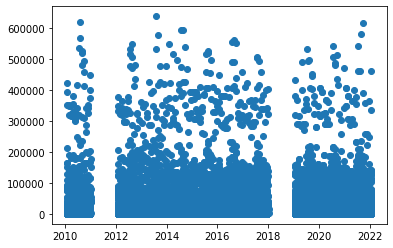

In [56]:
plt.scatter(df['ds'],df['y'])

{'whiskers': [<matplotlib.lines.Line2D at 0x14d632080>,
 'caps': [<matplotlib.lines.Line2D at 0x14d632620>,
 'boxes': [<matplotlib.lines.Line2D at 0x14d524f10>],
 'medians': [<matplotlib.lines.Line2D at 0x14d632bc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x14d632e90>],
 'means': []}

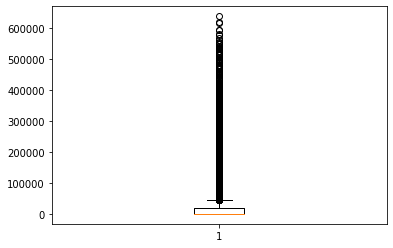

In [60]:
plt.boxplot(df['y'])

In [9]:
df2 = df.copy()
df2.head()

,Development Name,Borough,Account Name,Location,Meter AMR,Meter Scope,TDS #,EDP,RC Code,Funding Source,...,Rate Class,Bill Analyzed,y,KWH Charges,Consumption (KW),KW Charges,Other charges,year,month,day
0,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,GOV/NYC/068,Yes,128800,7387.97,216.0,2808.0,5200.85,2010,1,26
1,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,GOV/NYC/068,Yes,115200,6607.87,224.0,2912.0,5036.47,2010,2,25
2,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,GOV/NYC/068,Yes,103200,5919.55,216.0,2808.0,5177.43,2010,3,26
3,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,GOV/NYC/068,Yes,105600,6057.22,208.0,2704.0,6002.82,2010,4,26
4,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,GOV/NYC/068,Yes,97600,5598.34,216.0,2808.0,5323.20,2010,5,24


In [10]:
df2['avg_by_year'] = df2.groupby('year')['y'].transform('mean')
df2['avg_by_month'] = df2.groupby('month')['y'].transform('mean')
df2['avg_by_day'] = df2.groupby('ds')['y'].transform('mean')
df2 = df2[['ds','avg_by_year','avg_by_month','avg_by_day','Borough']]

In [11]:
df2.tail()

,ds,avg_by_year,avg_by_month,avg_by_day,Borough
406348,2021-09-22,22024.948729,27689.402915,20094.051948,BROOKLYN
406349,2021-10-22,22024.948729,20610.027879,15564.709677,BROOKLYN
406350,2021-11-22,22024.948729,19682.643247,12786.664430,BROOKLYN
406351,2021-12-23,22024.948729,21726.996966,13981.832215,BROOKLYN
406352,2022-01-25,22359.887574,22514.689847,15447.195946,BROOKLYN


In [17]:
df_by_year = df2.rename(columns={'avg_by_year':'y'})[['ds','y','Borough']].dropna().reset_index(drop=True)
df_by_month = df2.rename(columns={'avg_by_month':'y'})[['ds','y','Borough']].dropna().reset_index(drop=True)
df_by_day = df2.rename(columns={'avg_by_day':'y'})[['ds','y','Borough']].dropna().reset_index(drop=True)

In [18]:
df_by_year.tail()

,ds,y,Borough
21044,2021-09-22,22024.948729,BROOKLYN
21045,2021-10-22,22024.948729,BROOKLYN
21046,2021-11-22,22024.948729,BROOKLYN
21047,2021-12-23,22024.948729,BROOKLYN
21048,2022-01-25,22359.887574,BROOKLYN


In [39]:
df_by_year['y'].describe()

count    21045.000000
mean     22950.774483
std        823.462788
min      21706.534765
25%      22359.887574
50%      22925.097200
75%      23924.659259
max      24071.134700
Name: y, dtype: float64

In [41]:
df_by_month['y'].describe()

count    21049.000000
mean     22954.689962
std       3863.489015
min      19682.643247
25%      19929.905154
50%      20610.027879
75%      23232.728824
max      31182.732240
Name: y, dtype: float64

In [40]:
df_by_day['y'].describe()

count     21049.000000
mean      22954.689962
std       27475.572963
min           0.000000
25%       14101.791946
50%       16487.845912
75%       20936.621302
max      542000.000000
Name: y, dtype: float64

<AxesSubplot:ylabel='Count'>

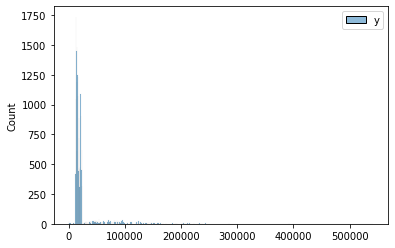

In [44]:
sns.histplot(df_by_day)

{'whiskers': [<matplotlib.lines.Line2D at 0x14b001a20>,
 'caps': [<matplotlib.lines.Line2D at 0x14b001fc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x14b000670>],
 'medians': [<matplotlib.lines.Line2D at 0x14b002560>],
 'fliers': [<matplotlib.lines.Line2D at 0x14b002830>],
 'means': []}

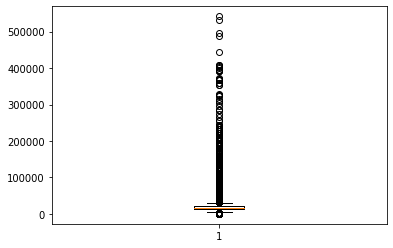

In [50]:
plt.boxplot(df_by_day['y'])

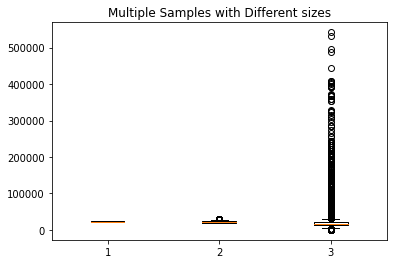

In [51]:
data = [df_by_year['y'], df_by_month['y'], df_by_day['y']]
fig, ax = plt.subplots()
ax.set_title('Multiple Samples with Different sizes')
ax.boxplot(data)

plt.show()

In [19]:
def plot_data_check(df):
    plt.scatter(df['ds'],df['y'])
    plt.axhline(df['y'].mean(),color="red")

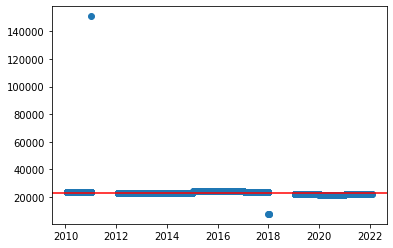

In [20]:
plot_data_check(df_by_year)

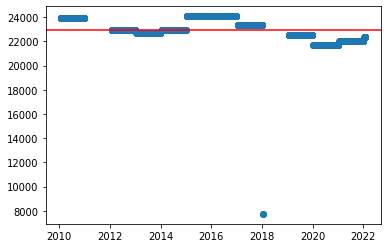

In [21]:
df_by_year = df_by_year.drop(index=[df_by_year[df_by_year['y']==df_by_year['y'].min()].index[0]], axis=0)
df_by_year = df_by_year.drop(index=[df_by_year[df_by_year['y']==df_by_year['y'].max()].index[0]], axis=0)
plot_data_check(df_by_year)

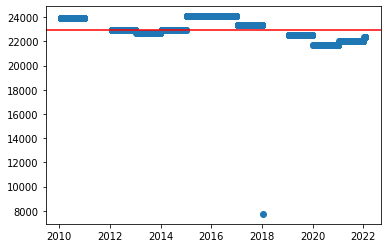

In [22]:
df_by_year = df_by_year.drop(index=[df_by_year[df_by_year['y']==df_by_year['y'].min()].index[0]], axis=0)
df_by_year = df_by_year.drop(index=[df_by_year[df_by_year['y']==df_by_year['y'].min()].index[0]], axis=0)
plot_data_check(df_by_year)

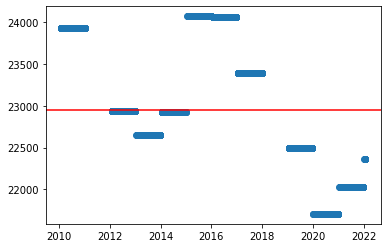

In [27]:
plot_data_check(df_by_year)

## Step Two: Fitting Model

In [28]:
def future_preds(df,period):
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(period) #period is in units of days
    forecast = m.predict(future)
    fig1 = m.plot(forecast);
    fig2 = m.plot_components(forecast);
    return (m, future, forecast, fig1, fig2)

In [29]:
df_by_year.isnull().sum() #df_by_month #

ds         0
y          0
Borough    0
dtype: int64

### By Year

In [76]:
m = Prophet()
m.fit(df_by_year)
future = m.make_future_dataframe(365) #period is in units of days
forecast = m.predict(future)

20:28:48 - cmdstanpy - INFO - Chain [1] start processing
20:29:34 - cmdstanpy - INFO - Chain [1] done processing


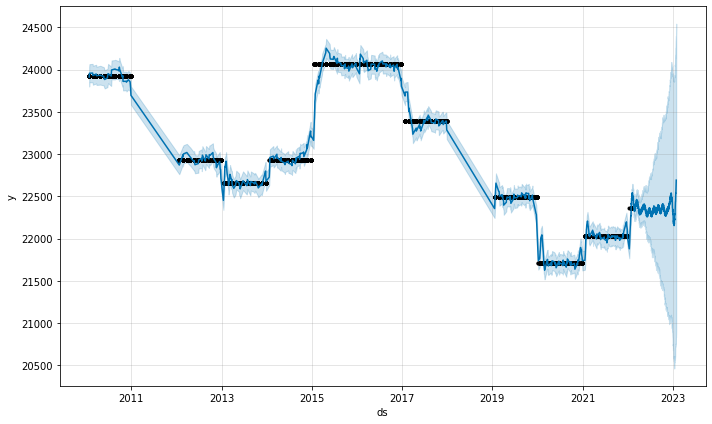

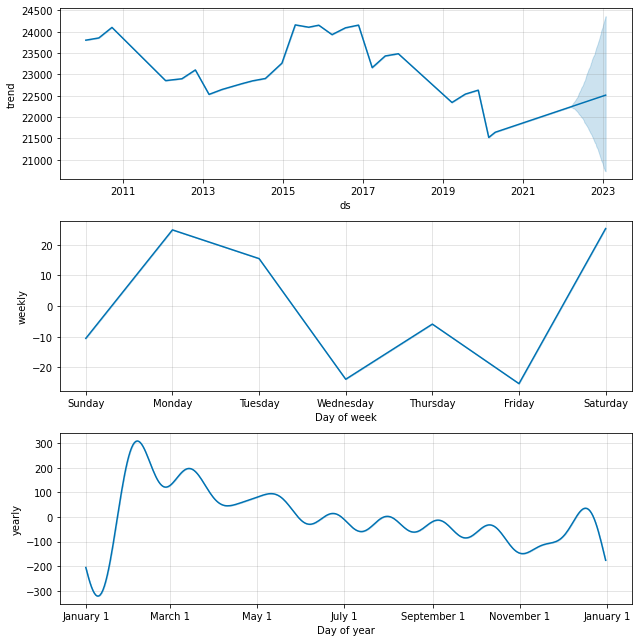

In [77]:
fig1 = m.plot(forecast);
fig2 = m.plot_components(forecast);

17:30:22 - cmdstanpy - INFO - Chain [1] start processing
17:31:09 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
829,2023-01-24,22538.235695,20600.004495,24276.699158
830,2023-01-25,22536.356055,20626.534415,24233.324571
831,2023-01-26,22591.083048,20641.814029,24263.075523
832,2023-01-27,22606.857201,20659.420042,24350.782044
833,2023-01-28,22690.973024,20781.348529,24406.784944


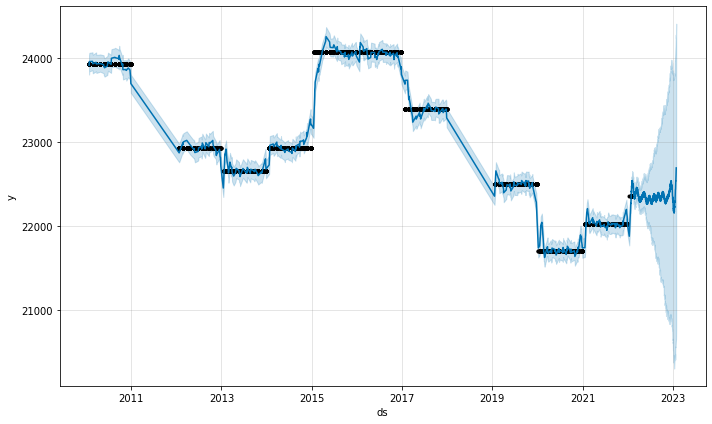

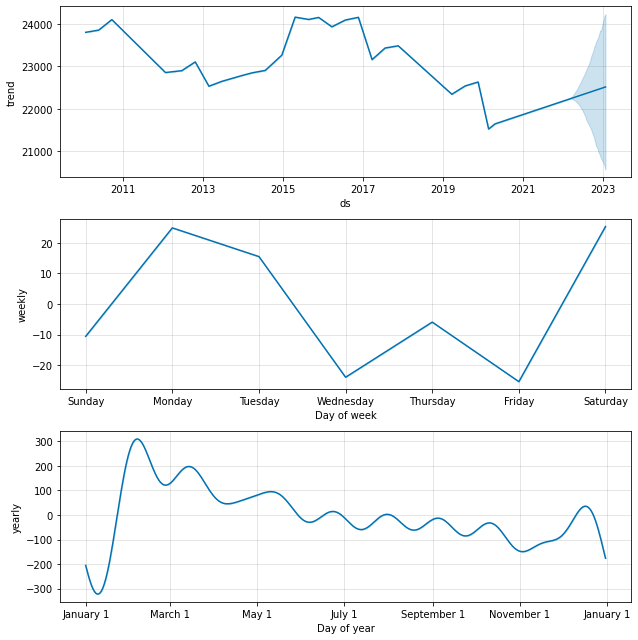

In [30]:
m_by_1_year, future_by_1_year, forecast_for_1_year, fig1, fig2 = future_preds(df_by_year,period=365)
forecast_for_1_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

17:31:44 - cmdstanpy - INFO - Chain [1] start processing
17:32:32 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
4114,2032-01-22,25263.666458,-40131.218867,95358.746602
4115,2032-01-23,25281.900376,-40018.554292,95520.494758
4116,2032-01-24,25370.660565,-40046.741728,95643.383841
4117,2032-01-25,25372.478145,-40117.940747,95697.764769
4118,2032-01-26,25444.937611,-40124.811479,95708.774620


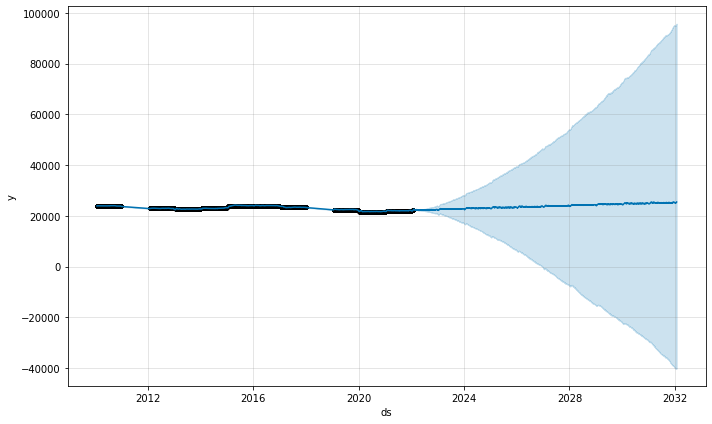

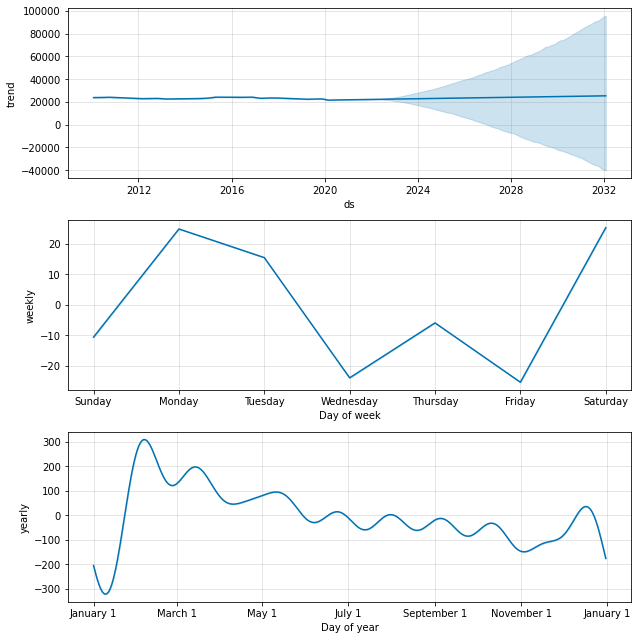

In [31]:
m_by_10_year, future_by_10_year, forecast_for_10_year, fig1, fig2 = future_preds(df_by_year,period=10*365)
forecast_for_10_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

17:32:51 - cmdstanpy - INFO - Chain [1] start processing
17:33:40 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
7764,2042-01-19,28316.265015,-151712.708470,207428.033293
7765,2042-01-20,28386.405674,-151587.632099,207503.596307
7766,2042-01-21,28413.273826,-151554.972171,207806.223827
7767,2042-01-22,28411.159977,-151512.665277,207680.829594
7768,2042-01-23,28467.134468,-151539.711222,207866.699042


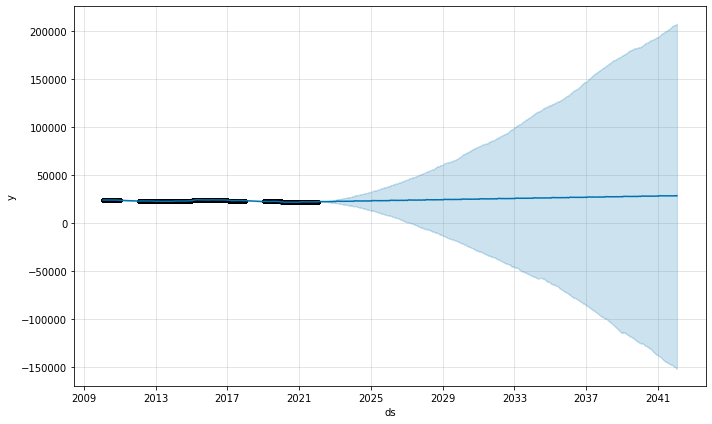

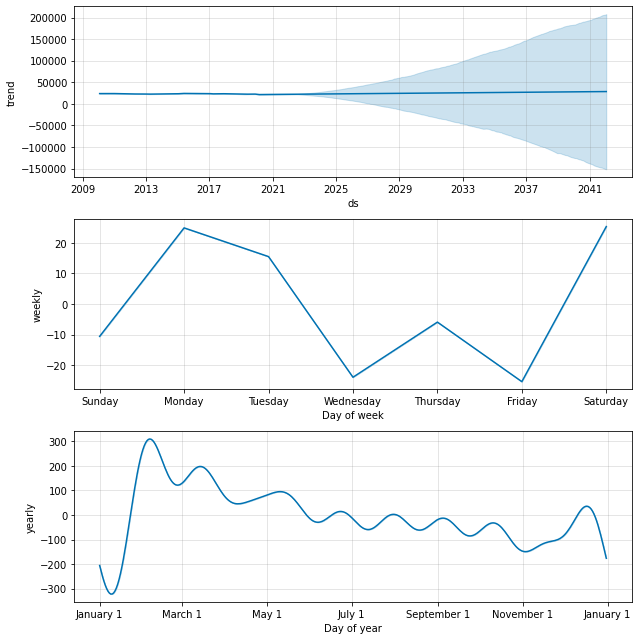

In [32]:
m_by_20_year, future_by_20_year, forecast_for_20_year, fig1, fig2 = future_preds(df_by_year,period=20*365)
forecast_for_20_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

### By Month

17:34:17 - cmdstanpy - INFO - Chain [1] start processing
17:34:32 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
497,2022-02-23,20365.942863,20207.979069,20518.275349
498,2022-02-24,20345.189409,20188.185792,20496.557940
499,2022-02-25,20307.778224,20156.266573,20473.316383
500,2022-02-26,20415.983553,20250.760093,20581.998882
501,2022-02-27,20312.124029,20157.748281,20487.532211


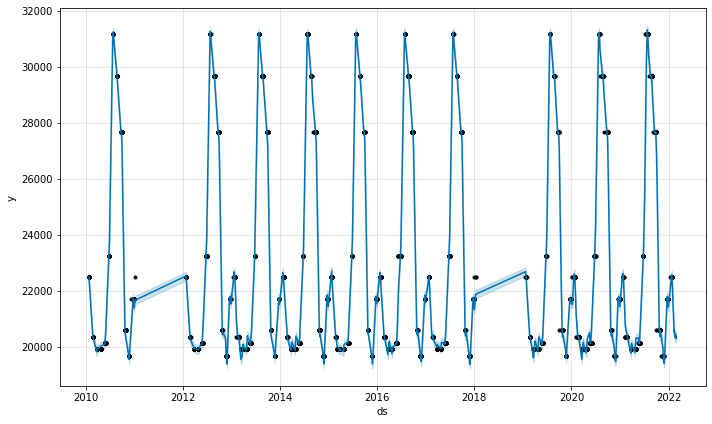

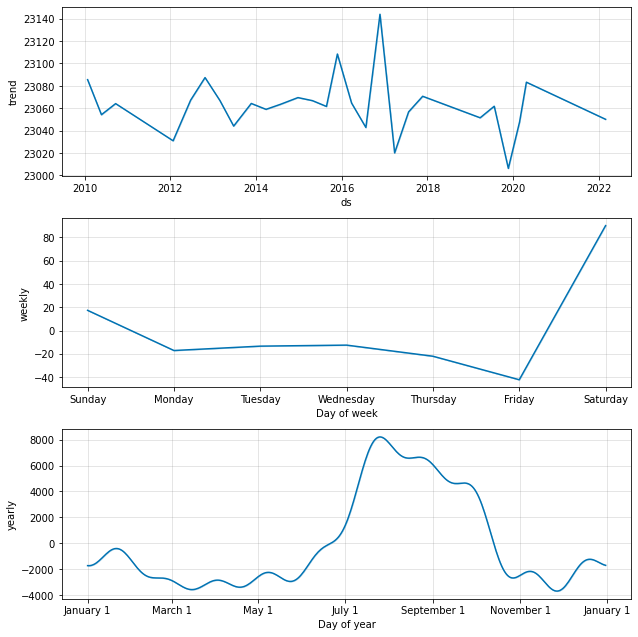

In [34]:
m_by_1_month, future_by_1_month, forecast_for_1_month, fig1, fig2 = future_preds(df_by_month,period=30)
forecast_for_1_month[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

17:35:10 - cmdstanpy - INFO - Chain [1] start processing
17:35:26 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
647,2022-07-23,31214.306771,31053.447595,31394.595548
648,2022-07-24,31215.807492,31068.430680,31388.190618
649,2022-07-25,31221.429085,31052.490346,31383.816553
650,2022-07-26,31233.053459,31066.839874,31402.780336
651,2022-07-27,31212.021925,31045.227199,31386.072031


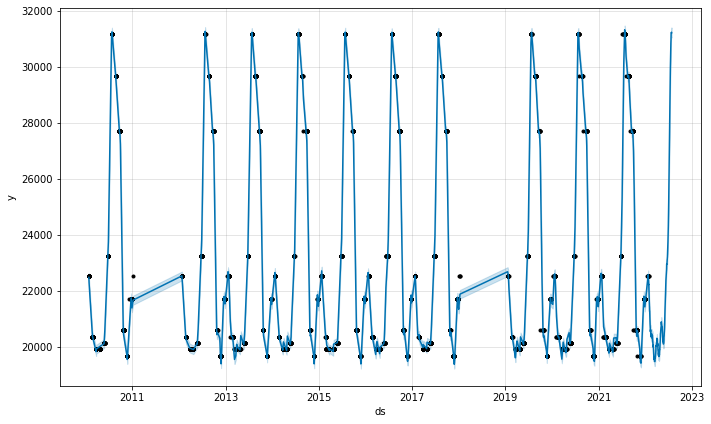

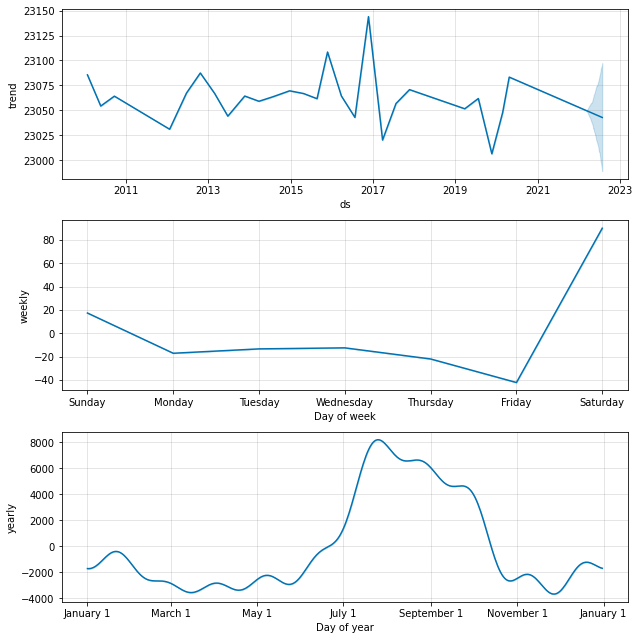

In [35]:
m_by_6_month, future_by_6_month, forecast_for_6_month, fig1, fig2 = future_preds(df_by_month,period=30*6)
forecast_for_6_month[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

17:35:35 - cmdstanpy - INFO - Chain [1] start processing
17:35:50 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
737,2022-10-21,20871.664307,20672.181626,21078.988320
738,2022-10-22,20835.663154,20629.989285,21032.883700
739,2022-10-23,20627.440276,20425.932078,20816.178340
740,2022-10-24,20489.504727,20292.228230,20668.575478
741,2022-10-25,20420.632327,20230.003098,20612.951724


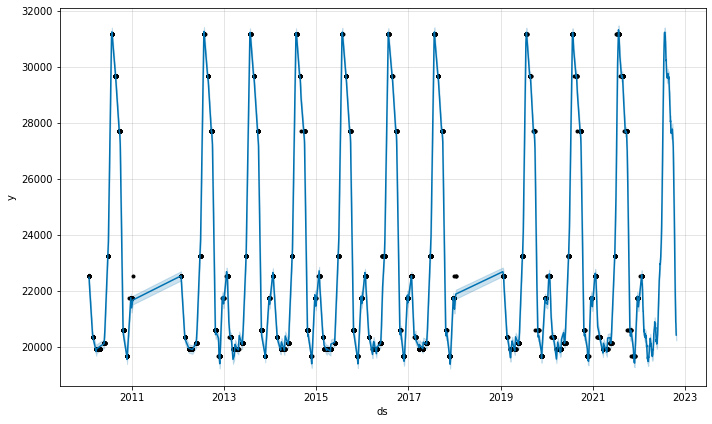

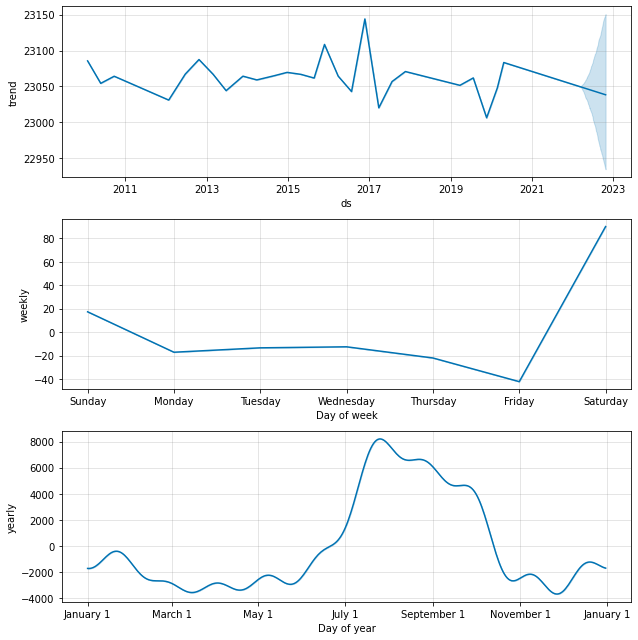

In [36]:
m_by_9_month, future_by_9_month, forecast_for_9_month, fig1, fig2 = future_preds(df_by_month,period=30*9)
forecast_for_9_month[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

### By Day

17:38:30 - cmdstanpy - INFO - Chain [1] start processing
17:38:32 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
567,2022-05-04,35539.880944,2862.812965,71953.646807
568,2022-05-05,34489.622840,-2900.322731,68150.990759
569,2022-05-06,33326.493610,-174.905464,68381.492901
570,2022-05-07,102007.067052,67165.050501,134826.345121
571,2022-05-08,103205.664946,67976.345799,136390.286011


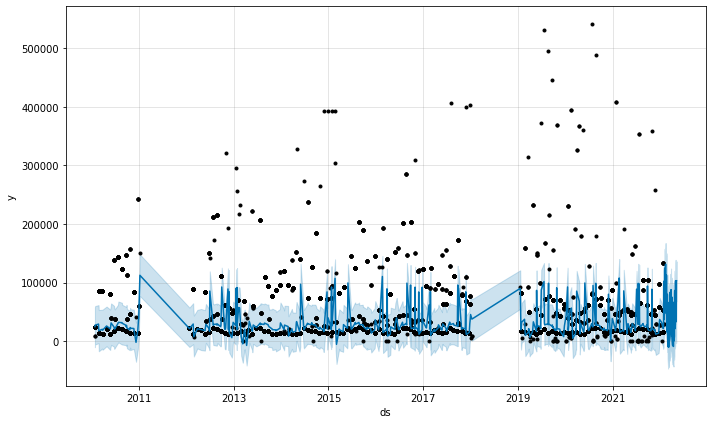

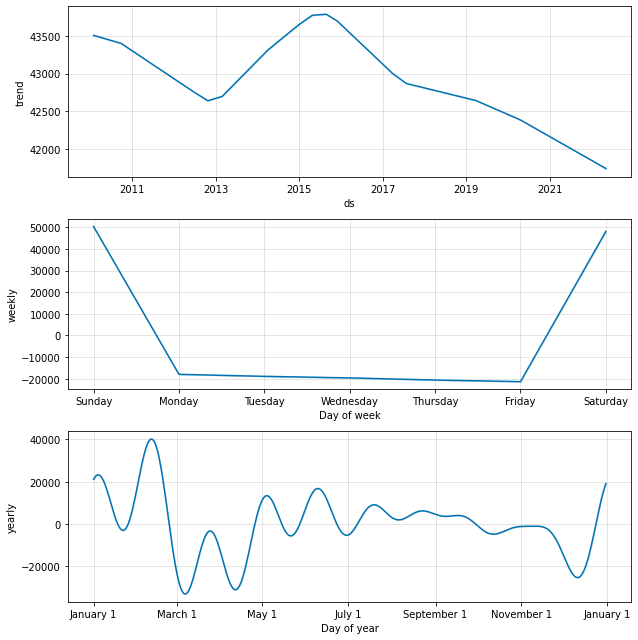

In [37]:
m_by_100_day, future_by_100_day, forecast_for_100_day, fig1, fig2 = future_preds(df_by_day,period=100)
forecast_for_100_day[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

20:11:59 - cmdstanpy - INFO - Chain [1] start processing
20:12:01 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
667,2022-08-12,23603.622780,-10627.835954,57037.587171
668,2022-08-13,93416.701776,60458.276884,127243.859646
669,2022-08-14,96050.486179,63025.184268,130562.389986
670,2022-08-15,28154.553591,-3055.207907,64685.652196
671,2022-08-16,27601.463280,-8372.355747,61592.173057


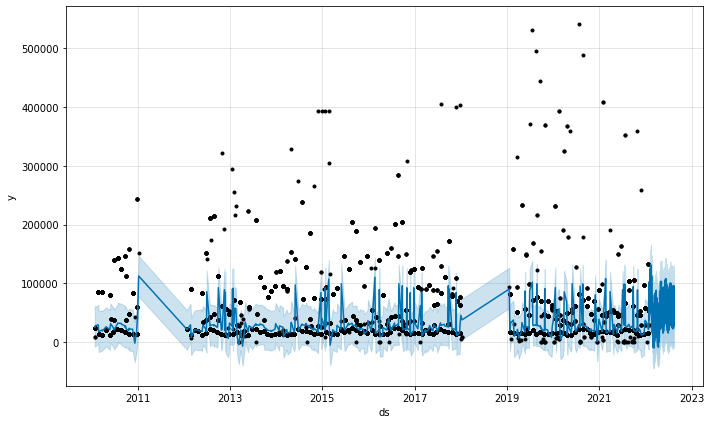

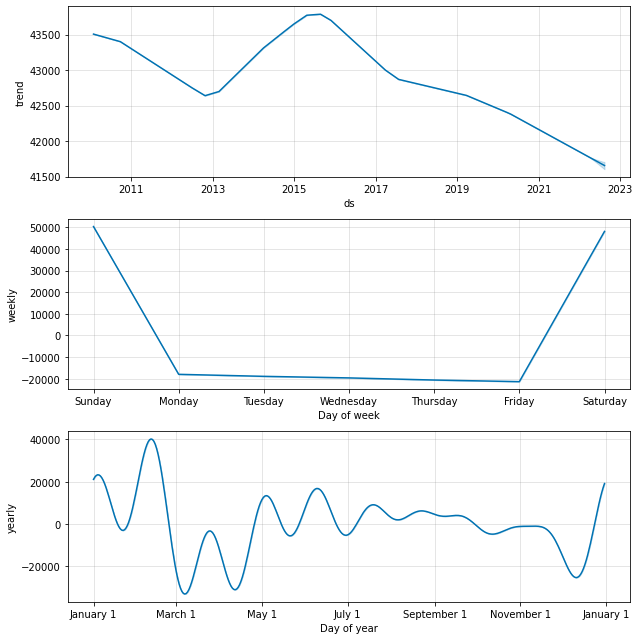

In [61]:
m_by_200_day, future_by_200_day, forecast_for_200_day, fig1, fig2 = future_preds(df_by_day,period=200)
forecast_for_200_day[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

20:12:07 - cmdstanpy - INFO - Chain [1] start processing
20:12:09 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
832,2023-01-24,20195.706272,-13803.885481,54107.868729
833,2023-01-25,20426.349859,-15326.780156,53028.242938
834,2023-01-26,20840.155361,-14712.265682,53685.649139
835,2023-01-27,21928.925796,-12163.376417,52795.336356
836,2023-01-28,93585.962810,59682.911194,127542.838910


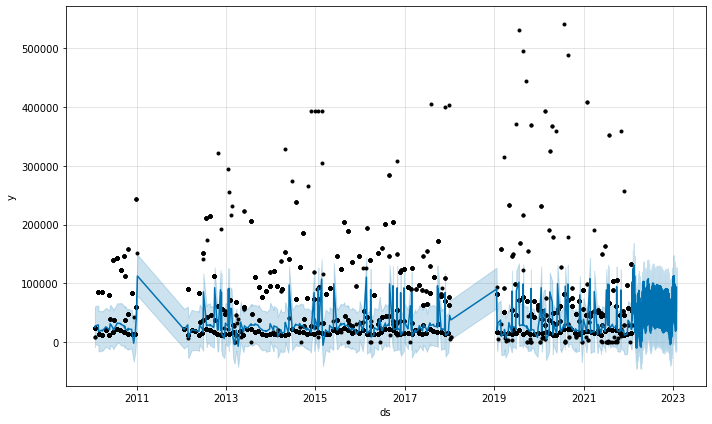

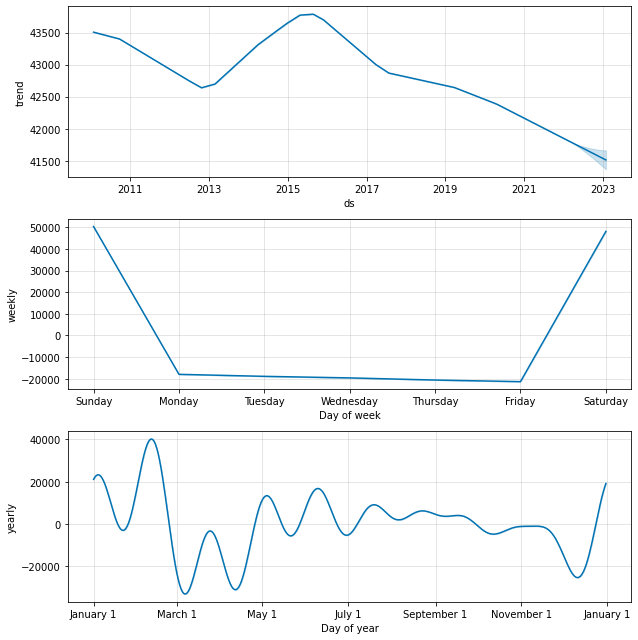

In [62]:
m_by_365_day, future_by_365_day, forecast_for_365_day, fig1, fig2 = future_preds(df_by_day,period=365)
forecast_for_365_day[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

## Step Three: Model Tuning

### Logistic Forecasting Growth

In [63]:
def future_preds_logistic(df,period,cap,growth):
    if growth == 'logistic':
        df['cap'] = cap
    m = Prophet(growth=growth)
    m.fit(df)
    future = m.make_future_dataframe(period) #period is in units of days
    future['cap'] = cap
    forecast = m.predict(future)
    fig1 = m.plot(forecast);
    fig2 = m.plot_components(forecast);
    return (m, future, forecast, fig1, fig2) 

20:15:56 - cmdstanpy - INFO - Chain [1] start processing
20:15:58 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
567,2022-05-04,26983.701272,-9758.362549,63306.489017
568,2022-05-05,25527.162131,-13715.162758,59320.974766
569,2022-05-06,23870.180596,-10609.709489,60144.419159
570,2022-05-07,-38035.461630,-73845.009877,-1341.230852
571,2022-05-08,-16664.284832,-53997.235372,18833.097156


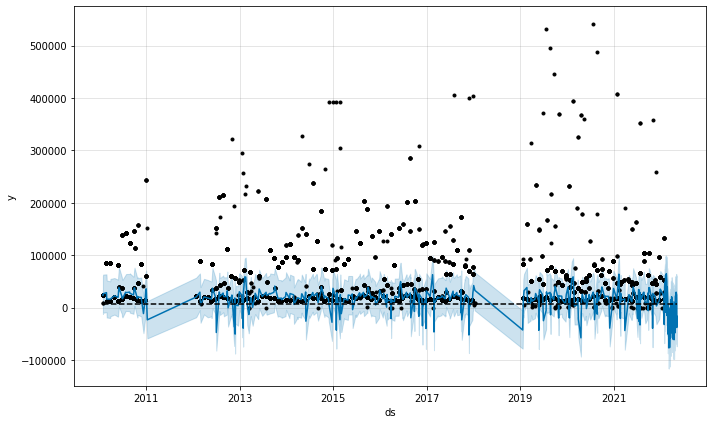

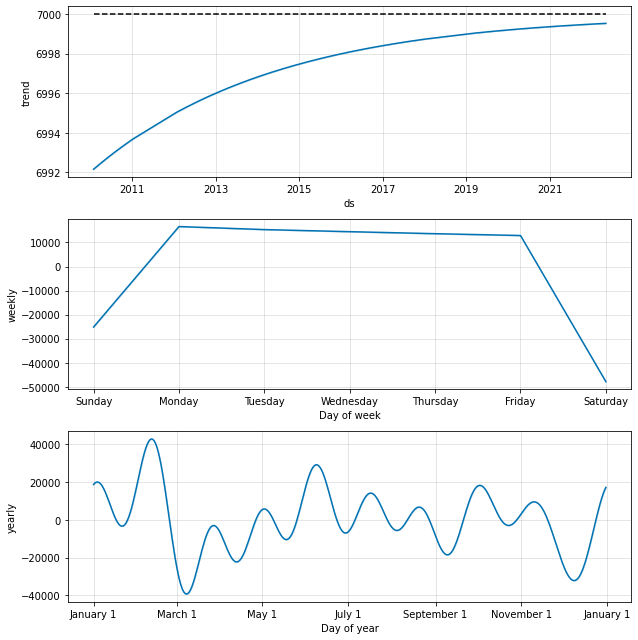

In [71]:
m_by_100_day_logistic, future_by_100_day_logistic, forecast_for_100_day_logistic, fig1, fig2 = future_preds_logistic(df_by_day,period=100,cap=7000,growth='logistic')
forecast_for_100_day_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
m_by_100_day_flat, future_by_100_day_flat, forecast_for_100_day_flat, fig1, fig2 = future_preds_logistic(df_by_day,period=100,cap=200,growth='flat')
forecast_for_100_day_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

### Seasonality 

In [ ]:
def future_preds_seasonality(df,period,growth='linear',cap=None,daily_seasonality=False,weekly_seasonality=False,
                            yearly_seasonality=False,name=None,period_for_seasonality=None,fourier_order=None,
                            changepoint_prior_scale=1,n_changepoints=30):
    if growth == 'logistic':
        df['cap'] = cap                        
    m = Prophet(growth,daily_seasonality=daily_seasonality,weekly_seasonality=weekly_seasonality,
                yearly_seasonality=yearly_seasonality,
                changepoint_prior_scale=changepoint_prior_scale,
                n_changepoints=n_changepoints)
    m.add_seasonality(name,period_for_seasonality,fourier_order)
    m.add_country_holidays(country_name='US')
    m.fit(df)
    future = m.make_future_dataframe(period) #period is in units of days
    forecast = m.predict(future)
    fig1 = m.plot(forecast);
    fig2 = m.plot_components(forecast);
    return (forecast)

In [ ]:
forecast_for_100_day_seasonality = future_preds_seasonality(df_by_day,period=100,weekly_seasonality=True,
                            yearly_seasonality=10,name='monthly',period_for_seasonality=25,fourier_order=10,
                            changepoint_prior_scale=1,n_changepoints=10)

In [ ]:
forecast_for_200_day_seasonality = future_preds_seasonality(df_by_day,period=200,weekly_seasonality=False,
                            yearly_seasonality=True,name='yearly',period_for_seasonality=25,fourier_order=10,
                            changepoint_prior_scale=1,n_changepoints=10)

In [ ]:
client = Client()  # connect to the cluster
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days',
                            parallel="dask")

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)



In [81]:
def hyperparamter_tuning(df, param_grid, initial='730 days', period='180 days', horizon='365 days',
                        parallel="dask"):
    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = []  # Store the RMSEs for each params here

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(df)  # Fit model with given params
        df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon, parallel=parallel)
        df_p = performance_metrics(df_cv, rolling_window=1)
        mapes.append(df_p['rmse'].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = mapes

    best_params = all_params[np.argmin(mapes)]

    return(m, df_cv, df_p, tuning_results, best_params)


In [82]:
client = Client()  # connect to the cluster
# df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days',
#                             parallel="dask")
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

hyperparamter_tuning(df, param_grid, initial='730 days', period='180 days', horizon='365 days',
                        parallel="dask")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62454 instead
  warnings.warn(
21:03:09 - cmdstanpy - INFO - Chain [1] start processing
21:03:12 - cmdstanpy - INFO - Chain [1] done processing
21:03:15 - cmdstanpy - INFO - Chain [1] start processing
21:03:15 - cmdstanpy - INFO - Chain [1] done processing
21:03:15 - cmdstanpy - INFO - Chain [1] start processing
21:03:15 - cmdstanpy - INFO - Chain [1] start processing
21:03:15 - cmdstanpy - INFO - Chain [1] done processing
21:03:15 - cmdstanpy - INFO - Chain [1] start processing
21:03:15 - cmdstanpy - INFO - Chain [1] done processing
21:03:16 - cmdstanpy - INFO - Chain [1] done processing
21:03:18 - cmdstanpy - INFO - Chain [1] start processing
21:03:18 - cmdstanpy - INFO - Chain [1] start processing
21:03:18 - cmdstanpy - INFO - Chain [1] start processing
21:03:18 -

(<prophet.forecaster.Prophet at 0x141eb5de0>,
               ds          yhat    yhat_lower     yhat_upper       y     cutoff
 0     2012-03-26  19685.929384 -52511.822250   96202.329747      47 2012-03-16
 1     2012-03-26  19685.929384 -56362.153064   94060.139467     810 2012-03-16
 2     2012-03-26  19685.929384 -55097.795571   95027.384150    8480 2012-03-16
 3     2012-03-26  19685.929384 -54742.286888   92809.110350      86 2012-03-16
 4     2012-03-26  19685.929384 -58140.083927   91786.120758   33280 2012-03-16
 ...          ...           ...           ...            ...     ...        ...
 36213 2022-01-26  23984.557654 -45706.348409  100021.661405   33600 2021-01-28
 36214 2022-01-26  23984.557654 -49308.121802  102458.036484   29680 2021-01-28
 36215 2022-01-26  23984.557654 -45672.117308  103702.784277  126680 2021-01-28
 36216 2022-01-28  28600.881977 -42871.097357   98989.206205   36400 2021-01-28
 36217 2022-01-28  28600.881977 -41558.873687  103860.110258   22480 2021-

In [ ]:
def hyperparamter_tuning(df, param_grid, cap,
                        initial='730 days', period='180 days', horizon='365 days',
                        parallel='dask',growth='linear',seasonality=False,country_holidays=False,
                        name=None, period_for_seasonality=None, fourier_order=None):

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = []  # Store the RMSEs for each params here

    if growth == 'logistic':
        df['cap'] = cap 

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params)

        if seasonality == True:
            m.add_seasonality(name,period_for_seasonality,fourier_order)
        if country_holidays == True:
            m.add_country_holidays(country_name='US')

        m.fit(df)  # Fit model with given params
        df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon, parallel=parallel)
        df_p = performance_metrics(df_cv, rolling_window=1)
        mapes.append(df_p['rmse'].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = mapes

    best_params = all_params[np.argmin(mapes)]

    return(m, df_cv, df_p, tuning_results, best_params)

In [ ]:
client = Client()  # connect to the cluster

param_grid = {  
    'n_changepoints': [],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'growth': ['linear','logistic','flat'],
    'cap': [3000, 4000, 5000, 6000, 7000, 8000, 9000],
    'daily_seasonality': [],
    'weekly_seasonality': [],
    'yearly_seasonality': []
}

m, df_cv, df_p, tuning_results, best_params = hyperparamter_tuning(df, param_grid, cap,
                        initial='730 days', period='180 days', horizon='365 days',
                        parallel='dask',growth='linear',seasonality=False,country_holidays=False,
                        name=None, period_for_seasonality=None, fourier_order=None)
    
    
    
    df, param_grid, initial='730 days', period='180 days', horizon='365 days',
                        parallel="dask")

                        

In [ ]:
fig = m_by_100_day_logistic.plot(forecast_for_100_day_logistic)
a = add_changepoints_to_plot(fig.gca(), m_by_100_day_logistic, forecast_for_100_day_logistic)

## Step Four: Model Evaluation

In [ ]:
initial = '365 days'
period = '365 days'
horizon = '365 days'
m = Prophet()
m.fit(df_by_month)
df_cv = cross_validation(m, initial, period, horizon)

In [ ]:
performance_metrics(df_cv)

## Step Five: Predictions by Borough

In [85]:
df2['Borough'].unique()

array(['BRONX', 'BROOKLYN', 'QUEENS', 'MANHATTAN', 'STATEN ISLAND'],
      dtype=object)

In [84]:
df2['avg_by_year'] = df2.groupby('Borough')['y'].transform('mean')